Попробуем решить головоломку c предыдущего семинара c помощью нейронной сети.

Импортируем нужные функции и модули:

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from collections import Counter
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

Как и обычно, нам понадобится функция для визуализации процесса обучения — очень важно понимать, что происходит, пока  мы учим нейронную сеть. Будем отслеживать значение функции ошибки и долю правильных ответов для обучающей выборки и валидации.

In [4]:
def plot_progress(train_losses, train_accs, val_loss, val_accs, epoch = 0):
    clear_output(True)

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    f.suptitle(f'{epoch} Epoch')


    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss', fontsize=14)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()

    ax2.plot(train_accs, label='train accuracy')
    ax2.plot(val_accs, label='val accuracy')
    ax2.plot(np.ones_like(accs), '--', label='100% accuracy')
    ax2.set_title('Accuracy', fontsize=14)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

# Подготовка

Прочитаем файл с данными и убедимся, что он считался верно:

In [ ]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/537384/sequence_puzzle.csv')
data.head()

,sequence,class
0,sjqaeauaknxxorozdxlmarrxrxdwgzaybz:lrphgjfltco...,1
1,nslqardijhgvtqetxkkbl:bvrfgyvmvbphltfjvvilxjat...,0
2,iyqzsuiflsqrcxvgdidnfvxkvzgiys:wnikygtgiyfhpyf...,0
3,rjooxlikqmpydfnibhawleeolfrcikpildaxxhumlawch:...,1
4,pqqsyndxhmdzekcqujpretnjfzzsbpjbjt:nywmpnrfret...,0


Посмотрим на баланс классов, длину строк в среднем и любые другие идеи, которые придут вам в голову:

In [ ]:
# <your beautiful code here>

In [ ]:
data.drop_duplicates().shape

(65536, 2)

In [ ]:
data.shape

(65536, 2)

In [ ]:
data['sequence'].apply(lambda x: len(x)).unique()

array([64])

In [ ]:
data['col'] = data['sequence'].apply(lambda x: x.find(':') >= 32)
data.head(30)

,sequence,class,col
0,sjqaeauaknxxorozdxlmarrxrxdwgzaybz:lrphgjfltco...,1,True
1,nslqardijhgvtqetxkkbl:bvrfgyvmvbphltfjvvilxjat...,0,False
2,iyqzsuiflsqrcxvgdidnfvxkvzgiys:wnikygtgiyfhpyf...,0,False
3,rjooxlikqmpydfnibhawleeolfrcikpildaxxhumlawch:...,1,True
4,pqqsyndxhmdzekcqujpretnjfzzsbpjbjt:nywmpnrfret...,0,True
5,jhzscqghvjdqzkdiiztqeapxwipdmoanljfxexk:cwevyv...,1,True
6,dsxlyxrvfcrigmbmdzyzqgvioglrywgwlucothsuwy:yvg...,0,True
7,aqfpyhpixafpgyxdubah:gcdfjsrateyhtjcbxjjucwean...,1,False
8,omrknlmrjcbcwavirhlsfxcototmzpskpb:jrjslznbtfo...,0,True
9,pwhjboxtbismzxucvzbapwcqweptkccbthiojxh:dinhvv...,1,True


Нам нужно закодировать последовательность перед тем, как подавать её в нейронную сеть — для этого реализуем нужные функции. Чтобы закодировать один элемент последовательности, нужно составить словари символов:

In [ ]:
letters = set(''.join(data.sequence))
n_letters = len(letters)

In [ ]:
letter_index_map = dict(zip(letters, range(n_letters)))
letter_index_map

{'r': 0,
 'y': 1,
 'q': 2,
 't': 3,
 ':': 4,
 's': 5,
 'k': 6,
 'z': 7,
 'u': 8,
 'l': 9,
 'm': 10,
 'f': 11,
 'j': 12,
 'b': 13,
 'w': 14,
 'e': 15,
 'o': 16,
 'c': 17,
 'n': 18,
 'g': 19,
 'd': 20,
 'i': 21,
 'h': 22,
 'p': 23,
 'x': 24,
 'a': 25,
 'v': 26}

Реализуем PyTorch Dataset — класс, переводящий одну строчку символов в последовательность индексов.

In [ ]:
class SequenceDataset(Dataset):

    def __init__(self, lines, labels):
        self.lines = lines
        self.labels = labels

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        x = self.line_to_tensor(self.lines[idx]).long()
        y = torch.tensor(self.labels[idx]).float()
        return x, y

    @staticmethod
    def line_to_tensor(line):
        return torch.tensor([letter_index_map[l] for l in line])

Разбиваем данные на обучающую и валидационную выборку, создаём соответствующие объекты DataLoader.

In [ ]:
np.mean(data['class'])

0.373809814453125

In [ ]:
data['class'].value_counts()

0    41038
1    24498
Name: class, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    data.sequence,
    data['class'],
    test_size=0.05,
)

train_dataset = SequenceDataset(lines=X_train.values, labels=y_train.values)
val_dataset = SequenceDataset(lines=X_val.values, labels=y_val.values)

In [ ]:
train_sequence_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_sequence_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

Разберём подробно архитектуру модели:

# Модели

## embedding -> CNN -> FC -> sigmoid

Обучаем эмбеддинги

In [ ]:
x = torch.from_numpy(
    np.random.randint(0, len(letter_index_map), (4, 64))
)
print('Our input sample\n', x, ' \nof size:', x.shape)

Our input sample
 tensor([[13, 14,  2, 13, 26, 14,  7, 17, 23, 22, 26, 20, 11,  8, 17, 10, 14,  7,
          7, 15, 17,  3,  6, 17,  0,  5, 11,  7,  7, 24, 18, 23, 11, 10, 26,  8,
          3, 14, 23, 16,  9, 15,  1,  2, 25, 11, 22, 19,  5, 18, 26,  1,  4, 22,
          0, 15,  6,  4,  4, 18, 24,  9, 17, 13],
        [ 6,  2, 10, 13,  5,  6, 25,  3, 20,  5, 15, 22, 22,  8, 13, 19,  7, 13,
         25, 21,  4,  1, 26, 23, 21, 12, 16,  0,  3,  6, 26, 14, 11,  0,  6,  8,
          0,  7,  1, 16, 22, 17, 20,  9,  5, 17, 14, 18, 12,  8,  4, 18, 15, 25,
         24, 23, 22, 14, 12, 25,  3,  1,  4,  0],
        [ 9, 19,  1,  3, 10, 23, 14, 18, 22,  6, 12, 12,  2,  6, 20,  2,  9, 17,
          3,  0, 18, 21, 20,  4, 22,  4, 20, 13, 19, 11,  6, 17, 17, 10, 11, 21,
          6, 18,  0,  0, 16,  4, 20, 17, 16, 18, 20,  3,  7,  2, 18, 17,  1, 22,
         14, 24, 17, 17, 21, 21, 15, 13,  4, 16],
        [ 0, 19,  1,  5,  6, 22, 14, 26, 23, 12, 20, 25,  5,  1,  8,  1, 21,  5,
          7, 13, 10,  

In [ ]:
emb_layer = nn.Embedding(num_embeddings=len(letter_index_map), embedding_dim=8)
emb_output = emb_layer(x)
emb_output.shape

torch.Size([4, 64, 8])

In [ ]:
emb_output

tensor([[[-0.4651,  0.9831, -2.4280,  ...,  0.3367, -1.2792, -0.9717],
         [ 0.1450,  0.4443,  1.6815,  ...,  0.1373, -0.3190,  0.0821],
         [-0.4278,  0.2382, -0.5226,  ..., -0.4246,  1.1391,  0.0255],
         ...,
         [ 1.0977,  0.6052,  1.9584,  ...,  0.1592, -0.1326, -0.6961],
         [ 0.2924, -1.3593,  0.6402,  ...,  0.5029,  0.1141, -1.5627],
         [-0.4651,  0.9831, -2.4280,  ...,  0.3367, -1.2792, -0.9717]],

        [[-3.4654,  3.1203,  1.3900,  ...,  1.3193,  0.3112, -0.6105],
         [-0.4278,  0.2382, -0.5226,  ..., -0.4246,  1.1391,  0.0255],
         [-0.9244,  0.3807,  0.2558,  ..., -1.9462,  1.2295, -1.8069],
         ...,
         [ 2.1162,  0.0662,  0.8494,  ...,  0.8970, -0.1668,  0.4340],
         [ 0.7252,  0.3709,  0.2060,  ..., -0.5370,  0.5240,  0.3539],
         [ 1.1913,  0.2733, -1.2670,  ..., -1.1011,  0.9750, -0.6946]],

        [[ 1.0977,  0.6052,  1.9584,  ...,  0.1592, -0.1326, -0.6961],
         [ 0.2575,  0.4575,  0.7763,  ..., -0

In [ ]:
emb_output[:, 0]

tensor([[-0.4651,  0.9831, -2.4280, -1.6312, -1.0502,  0.3367, -1.2792, -0.9717],
        [-3.4654,  3.1203,  1.3900,  3.0118,  1.0804,  1.3193,  0.3112, -0.6105],
        [ 1.0977,  0.6052,  1.9584, -0.8799, -1.2669,  0.1592, -0.1326, -0.6961],
        [ 1.1913,  0.2733, -1.2670, -1.3414,  0.8573, -1.1011,  0.9750, -0.6946]],
       grad_fn=<SelectBackward0>)

Посмотрим, как свёрточный слой преобразует данные. Для этого в выходе из эмбеддинг-слоя нужно поменять местами оси. Это можно сделать с помощью метода .permute():

In [ ]:
print(emb_output.shape)
print(emb_output.permute(0, 2, 1).shape)

torch.Size([4, 64, 8])
torch.Size([4, 8, 64])


Паддинг 'same' сохраняет исходную длину последовательности, при этом размерность векторов получается равной out_channels=16.

In [ ]:
conv1d = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=12, padding='same')

conv_output = conv1d(emb_output.permute(0, 2, 1))
conv_output.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([4, 16, 64])

Далее мы агрегируем всю информацию из последовательности с помощью вычисления максимума:

In [ ]:
max_output, l = conv_output.max(dim=-1)
conv_output.shape, max_output.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16]))

In [ ]:
conv_output[0, 0].argmax(), conv_output[0, 0].max(), l, max_output

(tensor(27),
 tensor(1.4738, grad_fn=<MaxBackward1>),
 tensor([[27, 17, 29, 29, 58, 40, 38, 51, 29, 29, 12,  3, 57, 16, 35, 51],
         [14, 29, 21,  3,  2, 36, 23, 27, 43, 25, 31, 38, 58, 12, 36, 59],
         [26, 44, 44, 34, 12, 38, 30, 26, 25, 53, 30, 10, 44, 31, 41, 36],
         [18, 25, 21,  7, 10, 13, 17, 35, 20, 53, 14,  6, 51, 17, 55,  4]]),
 tensor([[1.4738, 1.8367, 1.1512, 1.1930, 2.0649, 0.8949, 1.5224, 1.4358, 1.9959,
          1.8241, 1.1132, 1.0431, 1.0187, 0.7594, 1.3312, 1.2237],
         [1.3969, 1.6378, 1.1441, 1.6029, 1.5542, 0.9441, 1.8527, 1.7146, 1.4844,
          1.3379, 1.3413, 1.2562, 1.3021, 1.5574, 1.2901, 1.0539],
         [1.6125, 1.2110, 1.5269, 2.0292, 1.7951, 1.5604, 2.1767, 1.0303, 1.4435,
          1.3685, 2.1576, 1.6400, 1.2625, 1.4390, 1.7012, 1.4037],
         [1.3190, 0.8141, 1.3787, 1.2020, 1.4126, 0.8073, 1.3295, 1.3225, 1.2720,
          1.7513, 0.9830, 1.3357, 1.5058, 2.0198, 1.0612, 1.2543]],
        grad_fn=<MaxBackward0>))

## CNN

А теперь соберем все это воедино:

In [ ]:
class PuzzleCNN(nn.Module):

    def __init__(self, vocab_size, hidden_size, kernel_size=5, embedding_dim=8):
        super(PuzzleCNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.cnn = nn.Conv1d(embedding_dim, hidden_size, kernel_size=kernel_size, groups=2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x, _ = x.max(dim=-1)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x).squeeze()
        return x

In [ ]:
one_objext_batch_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
x, y = next(iter(one_objext_batch_dataloader))
print(x.shape)
print(x, y)

torch.Size([2, 64])
tensor([[ 5,  7, 25, 23, 21,  7, 22, 25,  7, 26,  8, 18, 16,  9,  8,  8,  6, 17,
         22, 21, 20, 23,  8,  4, 13,  5, 19, 15,  0, 11, 15,  3,  9,  2, 15, 20,
         23, 12, 14, 12,  2, 13, 10, 21, 11, 13,  0,  6, 22, 20, 12, 25,  8, 23,
         21, 24, 21, 12,  8, 19, 16,  8,  5, 14],
        [17, 14, 25, 24,  7,  0, 19,  6,  6, 19, 24, 26, 13, 19, 20, 14,  2,  4,
         25,  9,  9, 12, 24, 13,  6, 25, 24, 10, 15,  1, 15,  6, 18, 18, 12,  7,
         25,  9,  3, 19, 23,  0, 21, 16, 26,  3, 18, 10,  1, 11,  5, 17, 25,  9,
         24, 11, 17,  8,  2, 21, 20,  9, 24,  9]]) tensor([1., 0.])


Разберём цикл обучения:

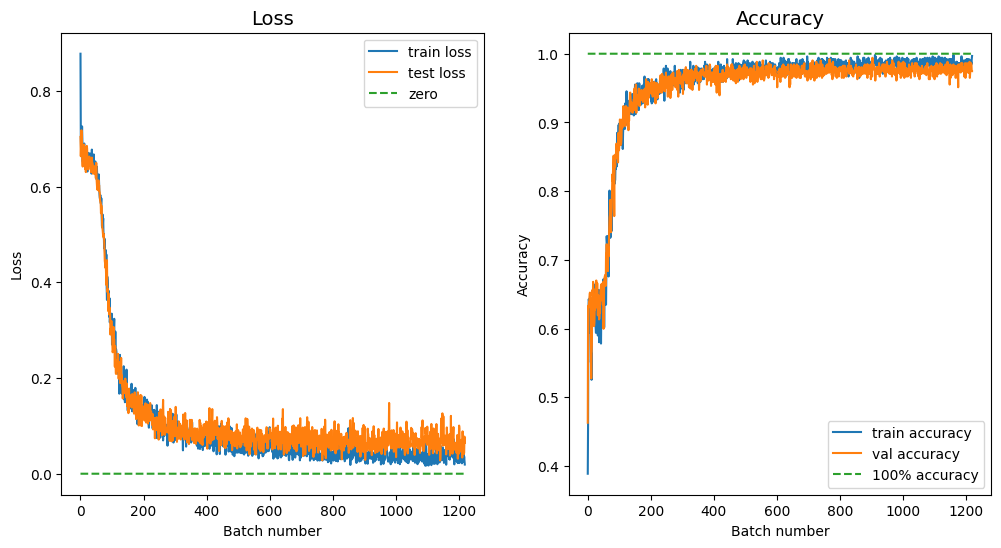

In [ ]:
# Инициализируем класс модели, размер внутреннего слоя 16, ширина окна 12
model = PuzzleCNN(
    vocab_size=len(letter_index_map),
    hidden_size=24,
    kernel_size=28,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Лосс функция – бинарная кросс энтропия (другое название logloss функции ошибки)
loss_func = nn.BCELoss()

n_epochs = 10

# Списки для сохранения истории функции ошибки и доли правильных ответов
losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:
        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()
        # не рассчитавать градиент по валидационной выборкке про grad и requires_grad

        x_val, y_val = next(iter(val_sequence_dataloader))
        #  генерируем один батч для валидации 0.5

        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()

        losses.append(train_loss.item())
        accs.append(train_acc.item())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        plot_progress(losses, accs, val_losses, val_accs)

In [ ]:
ans_df = pd.DataFrame({'preds': val_preds.detach().numpy(), 'y': y_val.detach().numpy()})
ans_df[(ans_df["y"] == 1.0) & (ans_df["preds"] <= 0.5)].count()

preds    6
y        6
dtype: int64

In [ ]:
ans_df[(ans_df["y"] == 0.0) & (ans_df["preds"] > 0.5)]

,preds,y
66,0.708296,0.0
144,0.976666,0.0
221,0.934153,0.0
226,0.885777,0.0
286,0.574807,0.0
400,0.902907,0.0
440,0.543207,0.0


Теперь посмотрим, как с решением головоломки справится другая архитектура, с которой мы познакомились на лекции — LSTM.

In [ ]:
accs[-1], val_accs[-1]

(0.9967426657676697, 0.974609375)

In [ ]:
accs[-1], val_accs[-1]

(0.9967426657676697, 0.974609375)

## LSTM

Какой LSTM брать?

In [ ]:
class PuzzleLSTM(nn.Module):

    def __init__(self, vocab_size, hidden_size, embedding_dim=8, bidirectional=False):
        super(PuzzleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.multiplier = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            bias=True,
            num_layers=1
        )
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.multiplier * hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        #x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze()
        x = self.linear(x)
        x = self.sigmoid(x.squeeze())
        return x

Архитектура сети во многом похожа PuzzleCNN: эмбеддинг-слой и линейный слой для бинарной классификации, но между ними вместо Conv1d уже стоит LSTM.

Посмотрим, как преобразует входные данные этот слой:

In [ ]:
lstm = nn.LSTM(input_size=8, hidden_size=16, num_layers=3)
outputs, (hiddens, cs) = lstm(emb_output)
outputs.shape

torch.Size([4, 64, 16])

Мы можем обучить LSTM для задачи классификации, применяя линейный слой к outputs для последнего токена:

In [ ]:
linear_layer = nn.Linear(16, 1)
linear_layer(outputs[:, -1, :].squeeze())

tensor([[0.0420],
        [0.0530],
        [0.0654],
        [0.0725]], grad_fn=<AddmmBackward0>)

Выход из линейного слоя преобразуем сигмоидой.

В nn.LSTM можно сразу получить выходы на нужное количество классов — для этого есть параметр proj_size, но мы использовали линейный слой для наглядности происходящего.

Обучим рекуррентную сеть решать задачу:

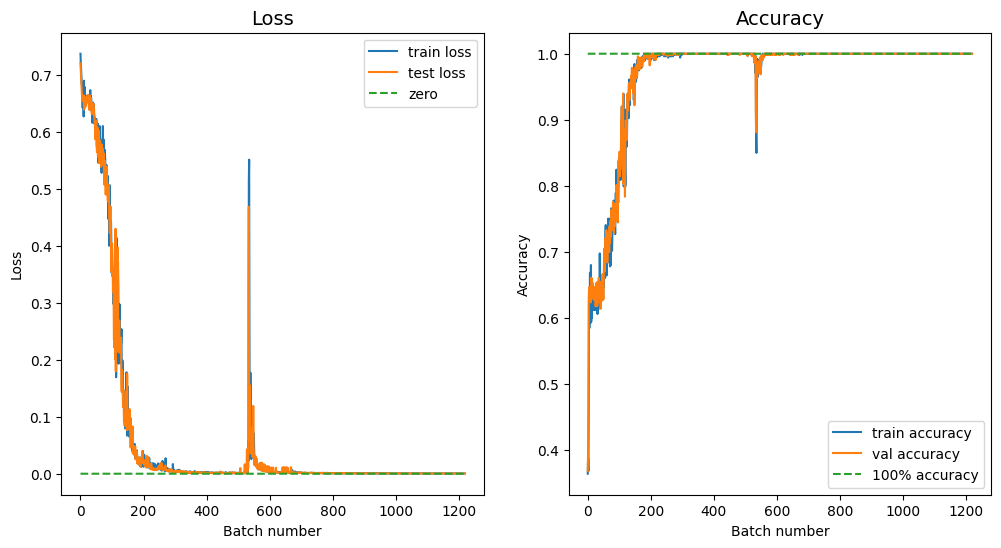

In [ ]:
# Инициализируем класс модели, размер внутреннего слоя 16
model = PuzzleLSTM(
    vocab_size=len(letter_index_map),
    hidden_size=16,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

n_epochs = 10


losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        model.eval()

        x_val, y_val = next(iter(val_sequence_dataloader))

        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()

        losses.append(train_loss.item())
        accs.append(train_acc.item())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        plot_progress(losses, accs, val_losses, val_accs)

Видим, что сеть успешно обучилась и предсказывает ответ со 100% точностью. Однако видно, что во время обучения возникали неприятные моменты, когда loss внезапно резко возрастал. Это как раз взрыв градиента, что мы обсуждали на лекции — бороться с ним можно, например, используя клиппинг:

In [86]:
# Инициализируем класс модели, размер внутреннего слоя 16
model = PuzzleLSTM(
    vocab_size=len(letter_index_map),
    hidden_size=16,
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()

n_epochs = 10


losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
    for x_train, y_train in train_sequence_dataloader:

        model.train()
        preds = model(x_train)
        train_loss = loss_func(preds, y_train)
        train_acc = ((preds > 0.5).long() == y_train).float().mean()

        optimizer.zero_grad()
        train_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        model.eval()

        x_val, y_val = next(iter(val_sequence_dataloader))

        val_preds = model(x_val)
        val_loss = loss_func(val_preds, y_val)
        val_acc = ((val_preds > 0.5).long() == y_val).float().mean()

        losses.append(train_loss.item())
        accs.append(train_acc.item())

        val_losses.append(val_loss.item())
        val_accs.append(val_acc.item())

        plot_progress(losses, accs, val_losses, val_accs)


KeyError: ignored

# Номера

## Кодирование

В данной задаче у нейронной сети должно быть три мультиклассовых выхода — свой выход для каждого из параметров (CarBrand, CarModel, Color).

In [5]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Mounted at /content/drive


In [6]:
df_train = pd.read_csv(way + "vins_train.csv")
df_train.head()

,VIN,CarBrand,CarModel,YearManufactured,EngineType,EngineVolume,Color
0,NVKZTHZ0X18TM05845,ВАЗ (LADA),2115 Samara,2009,Бензин,1.6,Серый
1,HNVKZXWFJ22J206195,ВАЗ (LADA),2112,2003,Бензин,1.6,Чёрный
2,HYQS2DXM922I900038,ВАЗ (LADA),21099,2003,Бензин,1.4,Серебряный
3,HNVKZF1KZ636X08104,ВАЗ (LADA),2110,1998,Бензин,1.6,Зелёный
4,EBLI88GR11J203825,Opel,Meriva,2008,Бензин,1.6,Чёрный


In [7]:
df_test = pd.read_csv(way + "vins_test.csv")
df_test.head()

,VIN
0,YQSR9TLW9JO00224
1,3I394K1QKM9H02594
2,EYQSM78R362WN07506
3,ENVKZF1KZ097TQ03193
4,HNVKZAHVI572HFP01935


In [8]:
def dict_making(bunch):
  for_dict = set(bunch)
  ret_dict = dict(zip(for_dict, range(len(for_dict))))
  return ret_dict

In [9]:
brand_dict = dict_making(df_train["CarBrand"])
brand_dict

{'Opel': 0, 'ВАЗ (LADA)': 1, 'Skoda': 2, 'Mazda': 3}

In [10]:
model_dict = dict_making(df_train["CarModel"])
model_dict

{'Familia': 0,
 'Premacy': 1,
 '2129': 2,
 'Calibra': 3,
 'Roomster': 4,
 'Insignia OPC': 5,
 '121': 6,
 'Vivaro': 7,
 'Sintra': 8,
 'Proceed': 9,
 'Fabia': 10,
 '2112': 11,
 'Eunos': 12,
 'Astra OPC': 13,
 'Cronos': 14,
 'Другая': 15,
 '2106': 16,
 'Capella': 17,
 'BT-50': 18,
 'Combo': 19,
 'Eunos Cosmo': 20,
 'Vectra OPC': 21,
 'Praktik': 22,
 'Roomster Scout': 23,
 '2110': 24,
 '2109': 25,
 'Ascona': 26,
 '323': 27,
 '6 MPS': 28,
 'Kapitan': 29,
 'Luce': 30,
 'Clef': 31,
 'Superb': 32,
 'Antara': 33,
 '2328': 34,
 'Biante': 35,
 'Largus': 36,
 'Tigra': 37,
 'Corsa OPC': 38,
 'XRAY': 39,
 'GT': 40,
 'Fabia Scout': 41,
 'Manta': 42,
 'Carol': 43,
 'B-Series': 44,
 'Vectra': 45,
 'Octavia Scout': 46,
 'Bongo Friendee': 47,
 'Commodore': 48,
 'Atenza': 49,
 'Astra GTC': 50,
 'Fabia RS': 51,
 'Octavia RS': 52,
 'Favorit': 53,
 '4x4 (Нива)': 54,
 'Revue': 55,
 'RX-7': 56,
 '2115 Samara': 57,
 '2105': 58,
 '2121 (4x4) Фора': 59,
 'Senator': 60,
 'Astra Family': 61,
 'MX-5': 62,
 '3': 63,


In [11]:
color_dict = dict_making(df_train["Color"])
color_dict

{'Оранжевый': 0,
 'Пурпурный': 1,
 'Бежевый': 2,
 'Серебряный': 3,
 'Синий': 4,
 'Фиолетовый': 5,
 'Жёлтый': 6,
 'Зелёный': 7,
 'Чёрный': 8,
 'Голубой': 9,
 'Белый': 10,
 'Красный': 11,
 'Розовый': 12,
 'Коричневый': 13,
 'Золотой': 14,
 'Серый': 15}

In [12]:
brand_num = len(brand_dict)
model_num = len(model_dict)
color_num = len(color_dict)

In [13]:
def recode(series, recode_dict):
    return series.map(recode_dict)

df_train_coded = df_train.copy()

df_train_coded["CarBrand"] = recode(df_train_coded["CarBrand"], brand_dict)
df_train_coded["CarModel"] = recode(df_train_coded["CarModel"], model_dict)
df_train_coded["Color"] = recode(df_train_coded["Color"], color_dict)


In [14]:
vin_len_max = df_train["VIN"].apply(lambda x: len(x))
vin_len_max = vin_len_max.max()
vin_len_max = int(vin_len_max)

In [15]:
df_train_coded["VIN"] = df_train_coded["VIN"].apply(lambda x: x.ljust(vin_len_max, '-'))

In [16]:
letters = ''.join(df_train_coded["VIN"])
letter_index_map = dict_making(letters)
letter_index_map

{'-': 0,
 '8': 1,
 '4': 2,
 'K': 3,
 'F': 4,
 '0': 5,
 'X': 6,
 'Q': 7,
 '1': 8,
 'N': 9,
 '5': 10,
 'U': 11,
 'S': 12,
 'Z': 13,
 'P': 14,
 '7': 15,
 'O': 16,
 'H': 17,
 '9': 18,
 'E': 19,
 'G': 20,
 'I': 21,
 'D': 22,
 'C': 23,
 'T': 24,
 '3': 25,
 'R': 26,
 'B': 27,
 '6': 28,
 '2': 29,
 'M': 30,
 'Y': 31,
 'L': 32,
 'W': 33,
 'V': 34,
 'A': 35,
 'J': 36}

In [17]:
df_train_coded.head()

,VIN,CarBrand,CarModel,YearManufactured,EngineType,EngineVolume,Color
0,NVKZTHZ0X18TM05845--,1,57,2009,Бензин,1.6,15
1,HNVKZXWFJ22J206195--,1,11,2003,Бензин,1.6,8
2,HYQS2DXM922I900038--,1,74,2003,Бензин,1.4,3
3,HNVKZF1KZ636X08104--,1,24,1998,Бензин,1.6,7
4,EBLI88GR11J203825---,0,88,2008,Бензин,1.6,8


In [18]:
class CarsDataset(Dataset):

    def __init__(self, vins, labels):
        self.vins = vins
        self.labels = labels

    def __len__(self):
        return len(self.vins)

    def __getitem__(self, idx):
        x = self.vin_to_tensor(self.vins[idx]).long()
        y = [torch.tensor(label) for label in self.labels[idx]]
        return x, y

    @staticmethod
    def vin_to_tensor(vin):
        return torch.tensor([letter_index_map[i] for i in vin])

In [19]:
labels = ["CarBrand", "CarModel", "Color"]

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train_coded["VIN"],
    df_train_coded[labels],
    test_size=0.1,
)

train_dataset = CarsDataset(vins=X_train.values, labels=y_train.values)
val_dataset = CarsDataset(vins=X_val.values, labels=y_val.values)

In [21]:
train_car_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_car_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)

## Нейронка

In [22]:
class CarLSTM(nn.Module):

    def __init__(self, vocab_size, hidden_size,
                 num_brands, num_models, num_colors,
                 embedding_dim=8, bidirectional=True):
        super(CarLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.multiplier = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
            bias=True,
            num_layers=3
        )
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.multiplier * hidden_size, 1)
        self.softmax = nn.Softmax(dim=1)

        self.brand_linear = nn.Linear(self.multiplier * hidden_size, num_brands)
        self.model_linear = nn.Linear(self.multiplier * hidden_size, num_models)
        self.color_linear = nn.Linear(self.multiplier * hidden_size, num_colors)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :].squeeze()

        brand_pred = self.brand_linear(x)
        model_pred = self.model_linear(x)
        color_pred = self.color_linear(x)

        brand_pred = self.softmax(brand_pred)
        model_pred = self.softmax(model_pred)
        color_pred = self.softmax(color_pred)

        return brand_pred, model_pred, color_pred

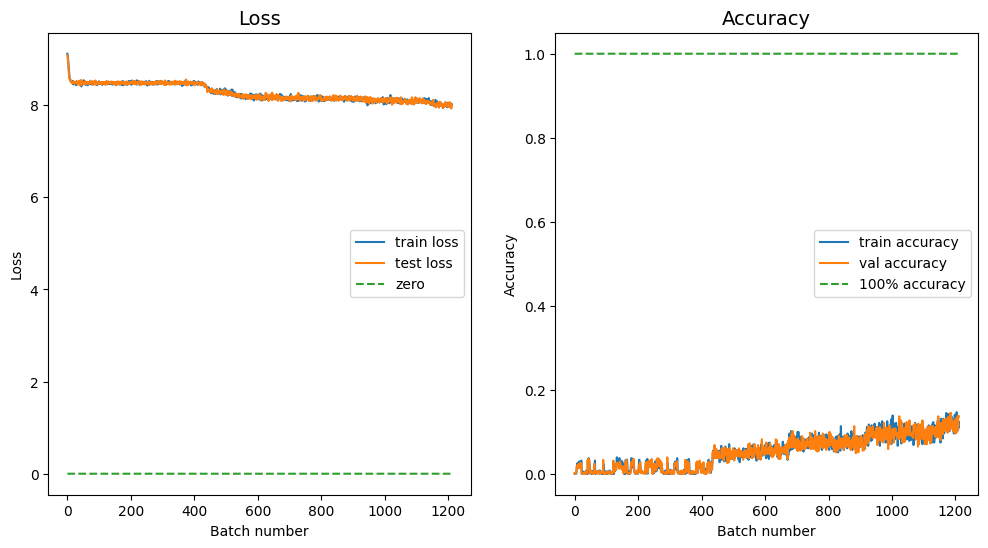

In [ ]:
model = CarLSTM(
    vocab_size=len(letter_index_map),
    hidden_size=20,
    num_brands=brand_num,
    num_models=model_num,
    num_colors=color_num
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
brand_head_loss_fn = nn.CrossEntropyLoss()
model_head_loss_fn = nn.CrossEntropyLoss()
color_head_loss_fn = nn.CrossEntropyLoss()

n_epochs = 10


losses = []
accs = []

val_losses = []
val_accs = []


for i in range(n_epochs):
  for x_train, y_train in train_car_dataloader:
    model.train()
    brand_preds, model_preds, color_preds = model(x_train)
    brand_head_loss = brand_head_loss_fn(brand_preds, y_train[0])
    model_head_loss = model_head_loss_fn(model_preds, y_train[1])
    color_head_loss = color_head_loss_fn(color_preds, y_train[2])

    total_loss = brand_head_loss + model_head_loss + color_head_loss

    _, brand_predicted_classes = torch.max(brand_preds, 1)
    _, model_predicted_classes = torch.max(model_preds, 1)
    _, color_predicted_classes = torch.max(color_preds, 1)

    brand_corr = (brand_predicted_classes == y_train[0])
    model_corr = (model_predicted_classes == y_train[1])
    color_corr = (color_predicted_classes == y_train[2])
    correct_predictions = brand_corr & model_corr & color_corr

    train_acc = correct_predictions.float().mean()

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    model.eval()

    x_val, y_val = next(iter(val_car_dataloader))


    val_brand_preds, val_model_preds, val_color_preds = model(x_val)
    val_brand_head_loss = brand_head_loss_fn(val_brand_preds, y_val[0])
    val_model_head_loss = model_head_loss_fn(val_model_preds, y_val[1])
    val_color_head_loss = color_head_loss_fn(val_color_preds, y_val[2])

    val_total_loss = val_brand_head_loss + val_model_head_loss + val_color_head_loss

    _, val_brand_predicted_classes = torch.max(val_brand_preds, 1)
    _, val_model_predicted_classes = torch.max(val_model_preds, 1)
    _, val_color_predicted_classes = torch.max(val_color_preds, 1)

    val_brand_corr = (val_brand_predicted_classes == y_val[0])
    val_model_corr = (val_model_predicted_classes == y_val[1])
    val_color_corr = (val_color_predicted_classes == y_val[2])
    val_correct_predictions = val_brand_corr & val_model_corr & val_color_corr

    val_acc = val_correct_predictions.float().mean()


    losses.append(total_loss.item())
    accs.append(train_acc.item())

    val_losses.append(val_total_loss.item())
    val_accs.append(val_acc.item())

    plot_progress(losses, accs, val_losses, val_accs, i)
